In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from keras.preprocessing import image

import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Import Data

In [49]:
styles_df = pd.read_csv('fashion-dataset/styles.csv',on_bad_lines='skip')
styles_df.index=styles_df['id']
styles_df.drop('id',axis=1,inplace=True)
styles_df.isna().sum()

gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [43]:
styles_df.masterCategory.value_counts()

masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

[Text(0, 0, 'Apparel'),
 Text(1, 0, 'Accessories'),
 Text(2, 0, 'Footwear'),
 Text(3, 0, 'Personal Care'),
 Text(4, 0, 'Free Items'),
 Text(5, 0, 'Sporting Goods'),
 Text(6, 0, 'Home')]

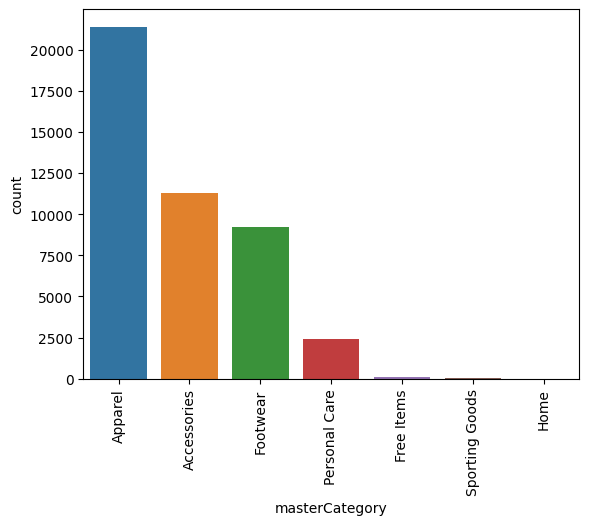

In [44]:
g=sns.countplot(x=styles_df['masterCategory'])
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [73]:
styles_df[styles_df['masterCategory']=='Home']

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
id,,,,,,,,,
40826,Unisex,Home,Home Furnishing,Cushion Covers,Yellow,Fall,2012.0,Home,Swayam Unisex Yellow and Orange Cushion Covers...


## 1.1 small classes

In [22]:
cats=styles_df.masterCategory.value_counts().sort_values(ascending=False).index

In [23]:
keep_df_sml_cls=styles_df[styles_df['masterCategory'].isin(cats[4:len(cats)])]

In [24]:
keep_df_sml_cls.shape

(131, 9)

In [25]:
keep_df_sml_cls['masterCategory'].replace({'Apparel':0,'Accessories':1,'Footwear':2,'Personal Care':3,
                                     'Free Items':4,'Sporting Goods':5,'Home':6},inplace=True)

In [32]:
prod_id_sml_cls = keep_df_sml_cls.index.to_numpy()

In [33]:
len(prod_id_sml_cls)

131

In [34]:
prod_id_sml_cls[0:10]

array([53598, 49696, 53591, 45894, 53596, 52676, 29975, 29981, 51091,
       54970], dtype=int64)

## 1.2 Import Images for small classes

In [35]:
image_path = 'fashion-dataset/images/'

IMG_SIZE = 224

In [36]:
def load_imgs(names):
    imgs = []
    for i, image_name in enumerate(tqdm(names)):
#         if i% 50 == 0 :
#             print(f"Loading Image {i}")
        try:
            img = image.load_img(f'{image_path}{image_name}.jpg', color_mode='rgb',target_size=(IMG_SIZE, IMG_SIZE))
        except:
            img = None
        if img is None:
            print(image_name)
            continue
            
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [45]:
images_sml_cls = load_imgs(prod_id_sml_cls)

In [39]:
images_sml_cls.shape

(0,)

In [16]:
gc.collect()

50

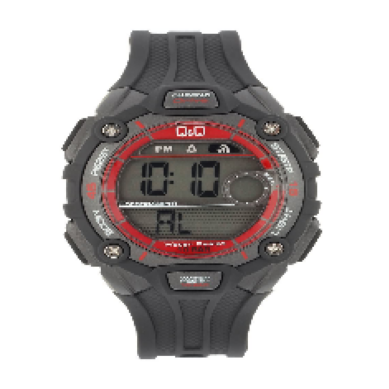

In [17]:
# plot some image

img = images_sml_cls[0]
plt.imshow(img)
plt.axis("off")
plt.show()

## 1.3 Apply ImageDataGenerator on small classes

In [18]:
import random, os

def set_seed(seed=123):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

In [19]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=50,
                             brightness_range=[0.15,2.0],
                             zoom_range=[5,0.5])

In [20]:
set_seed(seed=123)
x_batch_1, y_batch_1=datagen.flow(images_sml_cls,keep_df_sml_cls.masterCategory, 
                              batch_size=100, save_to_dir='fashion-dataset/gen_images/').next()

In [21]:
set_seed(seed=42)
x_batch_2, y_batch_2=datagen.flow(images_sml_cls,keep_df_sml_cls.masterCategory, 
                              batch_size=100, save_to_dir='fashion-dataset/gen_images/').next()

In [22]:
images_gen=np.vstack((x_batch_1,x_batch_2))
y_gen=np.hstack((y_batch_1,y_batch_2))

In [23]:
images_gen=images_gen.astype('uint8')

In [24]:
images_gen.dtype

dtype('uint8')

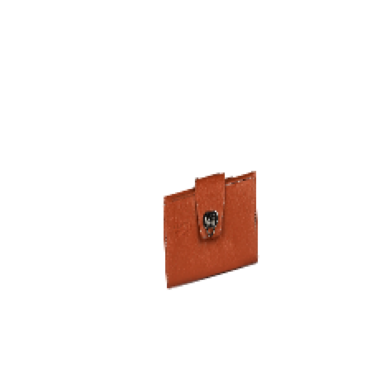

In [25]:
# plot some samples
img = images_gen[3]
plt.imshow(img)
plt.axis("off")
plt.show()

In [26]:
i_gen=0

if i_gen==1:
    set_seed(seed=123)
    j=0
    for x_batch, y_batch in datagen.flow(images_sml_cls,keep_df_sml_cls.masterCategory, 
                                         batch_size=32, save_to_dir='fashion-dataset/gen_images/'):
        
        if j==0:
            images_gen=x_batch
            y_gen=y_batch
        if j>0:
            images_gen=np.vstack((images_gen,x_batch))
            y_gen=np.concatenate((y_gen,y_batch))
        
        if j>3:
        #if j>= len(images_sml_cls) / 32:
            break
        j=+1
        

In [27]:
images_sml_cls=np.vstack((images_sml_cls,images_gen))
y_sml_cls=np.concatenate((keep_df_sml_cls.masterCategory.values,y_gen))

In [28]:
images_sml_cls.shape

(331, 224, 224, 3)

In [29]:
gc.collect()

4246

## 1.4 Select 1000 Images from Each large classes

In [30]:
keep_df_lrg_cls=pd.DataFrame()
for i in range(4):
    idx = styles_df[styles_df['masterCategory']==cats[i]].sample(1000,random_state=42).index
    keep_df_lrg_cls=pd.concat([keep_df_lrg_cls,styles_df.loc[idx.values,:]])
#
keep_df_lrg_cls.shape

(4000, 9)

In [31]:
keep_df_lrg_cls['masterCategory'].replace({'Apparel':0,'Accessories':1,'Footwear':2,'Personal Care':3,
                                     'Free Items':4,'Sporting Goods':5,'Home':6},inplace=True)

In [32]:
prod_id_lrg_cls = keep_df_lrg_cls.index.to_numpy()

In [33]:
len(prod_id_lrg_cls)

4000

## 1.5 Import Images for large classes

In [34]:
images_lrg_cls = load_imgs(prod_id_lrg_cls)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:25<00:00, 46.76it/s]


In [35]:
gc.collect()

0

In [36]:
images_lrg_cls.shape

(4000, 224, 224, 3)

# 2. Train_Test split

In [37]:
X=np.vstack((images_sml_cls,images_lrg_cls))

In [38]:
y=np.concatenate((y_sml_cls,keep_df_lrg_cls.masterCategory.values))

In [39]:
y.shape

(4331,)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123, test_size = 0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(3464, 224, 224, 3) (867, 224, 224, 3)
(3464,) (867,)


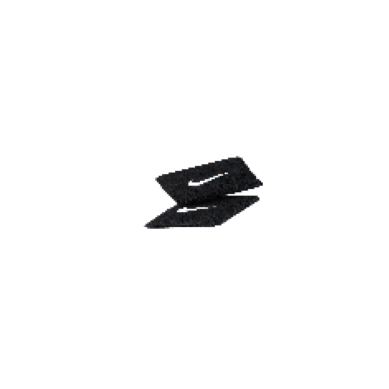

In [41]:
# plot some samples
img = X_train[0]
plt.imshow(img)
plt.axis("off")
plt.show()

In [42]:
y_train=to_categorical(y_train, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

In [43]:
X_train= preprocess_input(X_train) 
X_test= preprocess_input(X_test) 

In [57]:
np.save('X_train', X_train)

In [58]:
np.save('X_test', X_test)

In [44]:
np.save('y_train', y_train)

In [45]:
np.save('y_test', y_test)

In [47]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

# 3. Build Model

## Load train/test data

In [3]:
i_load_X=1

if i_load_X==1:
    X_train = np.load('X_train.npy')
    X_test = np.load('X_test.npy')
    y_train = np.load('y_train.npy')
    y_test = np.load('y_test.npy')    

## Check distribution of masterCategory in Train Data

In [69]:
np.unique(argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([787, 792, 808, 801, 223,  51,   2], dtype=int64))

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6')]

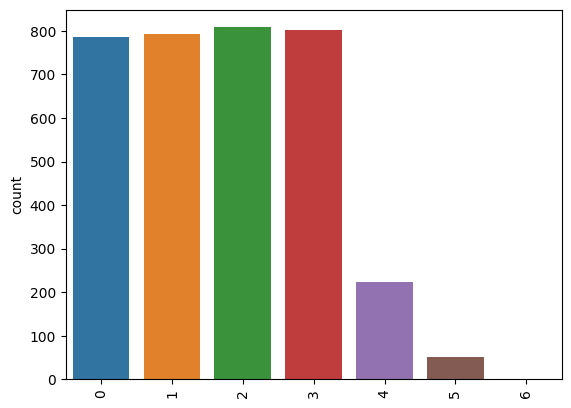

In [70]:
from numpy import argmax
g=sns.countplot(x=argmax(y_train,axis=1))
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## Check distribution of masterCategory in Test Data

In [66]:
np.unique(argmax(y_test,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([213, 208, 192, 199,  44,  11], dtype=int64))

In [71]:
np.unique(argmax(y_test,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([213, 208, 192, 199,  44,  11], dtype=int64))

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

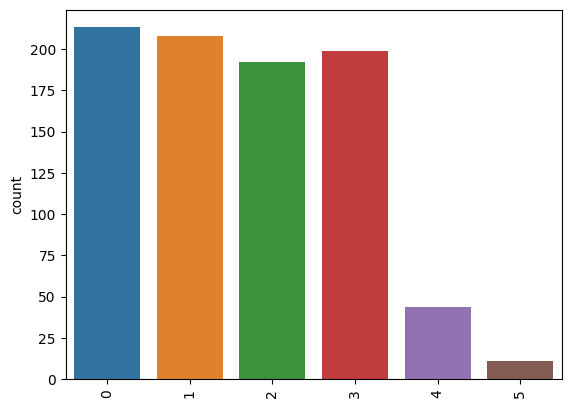

In [72]:
from numpy import argmax
g=sns.countplot(x=argmax(y_test,axis=1))
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## 3.1 Base Model

In [4]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights


## 3.2 Build CNN model 

In [6]:
def model_builder(hp):
    model = models.Sequential(layers=base_model.layers)
    model.add(layers.Flatten())

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    #hp_units = hp.Int('units', min_value=10, max_value=50, step=20)
    hp_units = hp.Choice('units', values=[20,40,50])
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(units=20, activation='relu'))   
    model.add(layers.Dense(7, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [7]:
tuner = kt.RandomSearch(model_builder,objective='val_accuracy',max_trials=6)

## 3.3 Hyperparameter Tuning 

In [8]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[es])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

Trial 6 Complete [01h 14m 04s]
val_accuracy: 0.9379509091377258

Best val_accuracy So Far: 0.9567099809646606
Total elapsed time: 09h 21m 38s
INFO:tensorflow:Oracle triggered exit
{'units': 20, 'learning_rate': 0.001}


In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 20, 'conditions': [], 'values': [20, 40, 50], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [14]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
(best_hps.get('units'),best_hps.get('learning_rate'))

(20, 0.001)

In [16]:
print(best_hps)

## 3.4 Train Model with Best Hyperparameters

In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
278/278 [==============================] - 894s 3s/step - loss: 1.2141 - accuracy: 0.7618 - val_loss: 0.7254 - val_accuracy: 0.8571
Epoch 2/50
278/278 [==============================] - 896s 3s/step - loss: 0.6416 - accuracy: 0.8614 - val_loss: 0.5206 - val_accuracy: 0.9048
Epoch 3/50
278/278 [==============================] - 895s 3s/step - loss: 0.5082 - accuracy: 0.8697 - val_loss: 0.5525 - val_accuracy: 0.8427
Epoch 4/50
278/278 [==============================] - 895s 3s/step - loss: 0.4442 - accuracy: 0.8824 - val_loss: 0.7100 - val_accuracy: 0.8874
Epoch 5/50
278/278 [==============================] - 914s 3s/step - loss: 0.4069 - accuracy: 0.8921 - val_loss: 0.5236 - val_accuracy: 0.8947
Epoch 6/50
278/278 [==============================] - 974s 4s/step - loss: 0.3913 - accuracy: 0.9008 - val_loss: 0.4119 - val_accuracy: 0.9091
Epoch 7/50
278/278 [==============================] - 953s 3s/step - loss: 0.3579 - accuracy: 0.9062 - val_loss: 0.4376 - val_accuracy: 0.9105

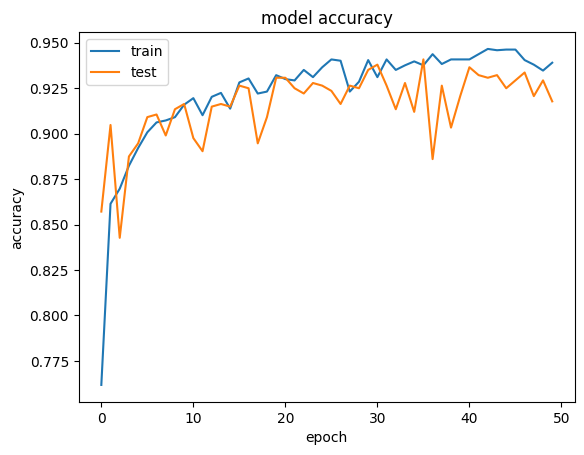

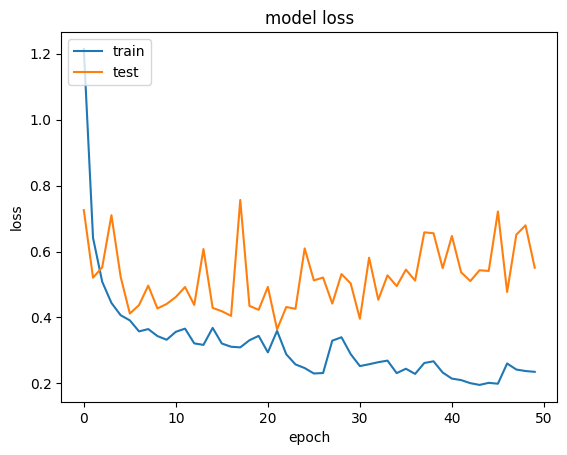

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# convert the history.history dict to a pandas DataFrame:     
hist_1st_tune_df = pd.DataFrame(history.history) 

# save to json:  
#hist_json_file = 'history.json' 
#with open(hist_json_file, mode='w') as f:
#    hist_df.to_json(f)

# or save to csv: 
file = 'first_tune_history.csv'
with open(file, mode='w') as f:
    hist_1st_tune_df.to_csv(f)

## 3.5 Retrain Model with Best epochs

In [10]:
##Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_final=hypermodel.fit(X_train, y_train, batch_size=10,epochs=best_epoch, validation_split=0.2)

Epoch 1/36
278/278 [==============================] - 6619s 24s/step - loss: 1.0512 - accuracy: 0.8004 - val_loss: 0.4896 - val_accuracy: 0.8889
Epoch 2/36
278/278 [==============================] - 895s 3s/step - loss: 0.4692 - accuracy: 0.8842 - val_loss: 0.3481 - val_accuracy: 0.9134
Epoch 3/36
278/278 [==============================] - 898s 3s/step - loss: 0.3602 - accuracy: 0.9101 - val_loss: 0.3945 - val_accuracy: 0.9120
Epoch 4/36
278/278 [==============================] - 907s 3s/step - loss: 0.2400 - accuracy: 0.9195 - val_loss: 0.3725 - val_accuracy: 0.9105
Epoch 5/36
278/278 [==============================] - 975s 4s/step - loss: 0.1961 - accuracy: 0.9379 - val_loss: 0.3638 - val_accuracy: 0.9437
Epoch 6/36
278/278 [==============================] - 924s 3s/step - loss: 0.1633 - accuracy: 0.9470 - val_loss: 0.5146 - val_accuracy: 0.9380
Epoch 7/36
278/278 [==============================] - 951s 3s/step - loss: 0.2016 - accuracy: 0.9433 - val_loss: 0.4782 - val_accuracy: 0.88

In [20]:
# convert the history.history dict to a pandas DataFrame:     
hist_2nd_tune_df = pd.DataFrame(history_final.history) 

# save to json:  
#hist_json_file = 'history.json' 
#with open(hist_json_file, mode='w') as f:
#    hist_df.to_json(f)

# or save to csv: 
file1 = 'epoch_10_history_with_Tuning.csv'
with open(file1, mode='w') as f:
    hist_2nd_tune_df.to_csv(f)

In [21]:
hist_2nd_tune_df

,loss,accuracy,val_loss,val_accuracy
0,1.051193,0.800433,0.489597,0.888889
1,0.469187,0.884157,0.348150,0.913420
2,0.360161,0.910141,0.394474,0.911977
3,0.239998,0.919524,0.372537,0.910534
4,0.196094,0.937929,0.363838,0.943723
5,0.163312,0.946951,0.514619,0.937951
6,0.201576,0.943342,0.478167,0.888889
7,0.183804,0.931072,0.462937,0.948052
8,0.161833,0.951281,0.368423,0.933622
9,0.149424,0.957055,0.428136,0.942280


## 3.6 Model Evalution

### Loss and Accuracy Scores

In [23]:
# evaluate hypermodel on test data
test_scores = hypermodel.evaluate(X_test, y_test, batch_size=10,verbose=0)
print("[test loss, test accuracy]:", test_scores)

[test loss, test accuracy]: [0.7647724151611328, 0.9446367025375366]


### Loss and Accuracy Plots

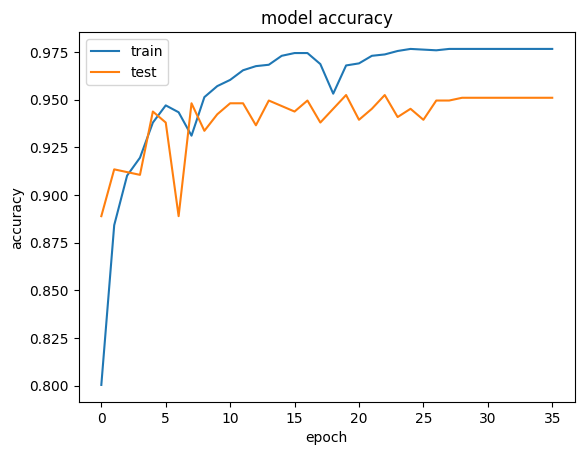

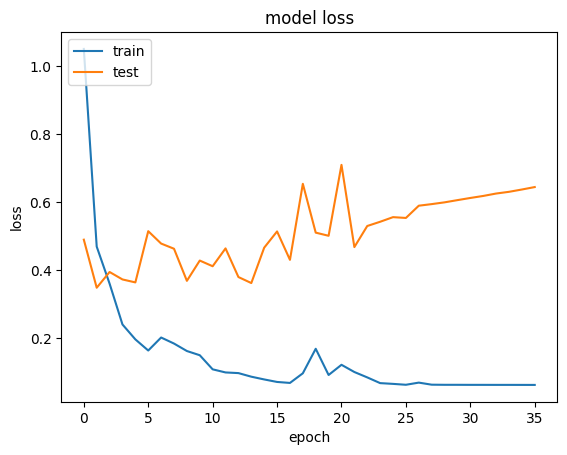

In [22]:
# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
#check the environment jupyter notebook is running 

#import sys
#print(sys.executable)

### Classification Reports on Test Data

In [24]:
y_pred = hypermodel.predict(X_test)               ## xtest => test image
y_test_class = np.argmax(y_test, axis=1)     ## ytest => test image's label
y_pred_class=np.argmax(y_pred, axis=1) 
print(classification_report(y_test_class, y_pred_class))
print(confusion_matrix(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       213
           1       0.90      0.94      0.92       208
           2       1.00      0.99      0.99       192
           3       0.99      0.98      0.99       199
           4       0.55      0.66      0.60        44
           5       0.00      0.00      0.00        11

    accuracy                           0.94       867
   macro avg       0.74      0.76      0.75       867
weighted avg       0.94      0.94      0.94       867

[[208   3   0   0   2   0]
 [  1 196   0   0  11   0]
 [  1   0 190   0   1   0]
 [  0   3   0 196   0   0]
 [  0  14   0   1  29   0]
 [  0   1   0   0  10   0]]


## 3.7 Save Hypermodel 

In [25]:
# serialize model to JSON
hypermodel_json = hypermodel.to_json()
with open("hypermodel.json", "w") as json_file:
    json_file.write(hypermodel_json)
    
# serialize weights to HDF5
hypermodel.save_weights("hypermodel.h5")
print("Saved hypermodel to disk")

Saved hypermodel to disk


## 3.8 Load Hypermodel 

In [6]:
# load json and create model
json_file = open('hypermodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
hypermodel = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("hypermodel.h5")
print("Loaded hypermodel from disk")

Loaded model from disk


In [7]:
hypermodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])